In [1]:
import asyncio
import itertools
import logging
import random
import nest_asyncio
nest_asyncio.apply()# must be run at the start of every notebook to patch the event loop to allow nesting, eg. so we can run asyncio.run from within a notebook.

In [2]:
import os
from pathlib import Path
import tempfile

from shutil import rmtree
from typing import List, Optional, Union


In [3]:
# Adjust your env variables here if nescesary
%pwd
%env NUPLAN_DATA_ROOT=../../../datasets/nuplan/dataset
%env NUPLAN_MAPS_ROOT=../../data/nuplan/maps
%env NUPLAN_EXP_ROOT=../../data/nuplan/exp
%env NUPLAN_DEVKIT_ROOT=../../nuplan-devkit/

env: NUPLAN_DATA_ROOT=../../../datasets/nuplan/dataset
env: NUPLAN_MAPS_ROOT=../../data/nuplan/maps
env: NUPLAN_EXP_ROOT=../../data/nuplan/exp
env: NUPLAN_DEVKIT_ROOT=../../nuplan-devkit/


In [4]:
import hydra
import pytorch_lightning as pl
from omegaconf import DictConfig, OmegaConf

from nuplan.common.utils.s3_utils import is_s3_path
from nuplan.planning.script.builders.simulation_builder import build_simulations
from nuplan.planning.script.builders.simulation_callback_builder import (
    build_callbacks_worker,
    build_simulation_callbacks,
)
from nuplan.planning.script.utils import run_runners, set_default_path, set_up_common_builder
from nuplan.planning.simulation.planner.abstract_planner import AbstractPlanner

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# If set, use the env. variable to overwrite the default dataset and experiment paths
set_default_path()

# If set, use the env. variable to overwrite the Hydra config
CONFIG_PATH = os.getenv('NUPLAN_HYDRA_CONFIG_PATH', 'config/simulation')

if os.environ.get('NUPLAN_HYDRA_CONFIG_PATH') is not None:
    CONFIG_PATH = os.path.join('../../../../', CONFIG_PATH)

if os.path.basename(CONFIG_PATH) != 'simulation':
    CONFIG_PATH = os.path.join(CONFIG_PATH, 'simulation')
CONFIG_NAME = 'default_simulation'

In [5]:
from tutorials.utils.tutorial_utils import construct_simulation_hydra_paths

# Location of paths with all simulation configs
BASE_CONFIG_PATH = os.path.join(os.getenv('NUPLAN_TUTORIAL_PATH', ''), '../nuplan/planning/script')
simulation_hydra_paths = construct_simulation_hydra_paths(BASE_CONFIG_PATH)

# Create a temporary directory to store the simulation artifacts

DATASET_PARAMS = [
    'scenario_builder=nuplan_mini',  # use nuplan mini database (2.5h of 8 autolabeled logs in Las Vegas)
    'scenario_filter=all_scenarios',  # initially select all scenarios in the database
#     'scenario_filter.scenario_types=[near_multiple_vehicles, on_pickup_dropoff, starting_unprotected_cross_turn, high_magnitude_jerk]',  # select scenario types
    'scenario_filter.scenario_types=[starting_unprotected_cross_turn, near_multiple_vehicles]',  # [near_multiple_vehicles, on_pickup_dropoff, starting_unprotected_cross_turn, high_magnitude_jerk]',  # select scenario types
    'scenario_filter.num_scenarios_per_type=2',  # use 10 scenarios per scenario type
#     'scenario_filter=one_continuous_log',  # simulate only one log
#     "scenario_filter.log_names=['2021.06.14.16.48.02_veh-12_04057_04438']",
     'scenario_filter.limit_total_scenarios=4',  # use 1 total scenarios
]
ckpt_dir = '/home/ehdykhne/Repos/nuplan-devkit/experiments/pretrained_checkpoints/pdm_offset_checkpoint.ckpt'
#'/home/sacardoz/checkpoints/urbandriver_checkpoint.ckpt'
#"/home/sacardoz/tutorial_vector_framework/training_simple_vector_experiment/train_default_simple_vector/2023.11.23.09.55.21/best_model/epoch.ckpt"
#"/home/sacardoz/training_raster_experiment/train_default_raster/2023.11.23.07.36.36/best_model/epoch.ckpt"
# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=simulation_hydra_paths.config_path)

# Compose the configuration
print(simulation_hydra_paths.config_name)
cfg = hydra.compose(config_name=simulation_hydra_paths.config_name, overrides=[
    '+simulation=open_loop_boxes',# [open_loop_boxes, closed_loop_nonreactive_agents, closed_loop_reactive_agents]
    #'model=pgm_hybrid_model',
#     'planner=pdm_hybrid_planner',
#     f"planner.pdm_hybrid_planner.checkpoint_path={ckpt_dir}" ,
    'planner=log_future_planner', 
    'ego_controller=perfect_tracking_controller',
    #'planner.ml_planner.model_config=${model}',
    #f'planner.ml_planner.checkpoint_path={ckpt_dir}',
    #f'observation=idm_agents_observation',
    #'observation.model_config=${model}',
    #f'observation.checkpoint_path={ckpt_dir}',
    'worker=sequential',
    '+occlusion=true',
    '+occlusion.manager_type=wedge', #options: [range, shadow, wedge]
    "hydra.searchpath=[pkg://tuplan_garage.planning.script.config.common, pkg://tuplan_garage.planning.script.config.simulation, pkg://nuplan.planning.script.config.common, pkg://nuplan.planning.script.experiments]",
    *DATASET_PARAMS,
])

output_folder = cfg.output_dir
print(output_folder)

default_simulation
../../data/nuplan/exp/exp/simulation/open_loop_boxes/2023.12.08.22.08.14


# Now we can run with the following

Global seed set to 0
INFO:nuplan.planning.script.builders.main_callback_builder:Building MultiMainCallback...
INFO:nuplan.planning.script.builders.main_callback_builder:Building MultiMainCallback: 4...DONE!


2023-12-08 22:08:15,778 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:19}  Building WorkerPool...
2023-12-08 22:08:15,779 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:101}  Worker: Sequential
2023-12-08 22:08:15,779 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:102}  Number of nodes: 1
Number of CPUs per node: 1
Number of GPUs per node: 0
Number of threads across all nodes: 1
2023-12-08 22:08:15,779 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:27}  Building WorkerPool...DONE!
2023-12-08 22:08:15,779 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:32}  Building experiment folders...
2023-12-08 22:08:15,779 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:35}  

	Folder where all results are stored: ../../data/nuplan/exp/exp/simulation/open_loop_b

Rendering histograms: 100%|██████████| 10/10 [00:01<00:00,  7.24it/s]


2023-12-08 22:08:42,889 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/main_callback/metric_summary_callback.py:344}  Metric summary: 00:00:02 [HH:MM:SS]
2023-12-08 22:08:42,889 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/run_simulation.py:116}  Finished running simulation!


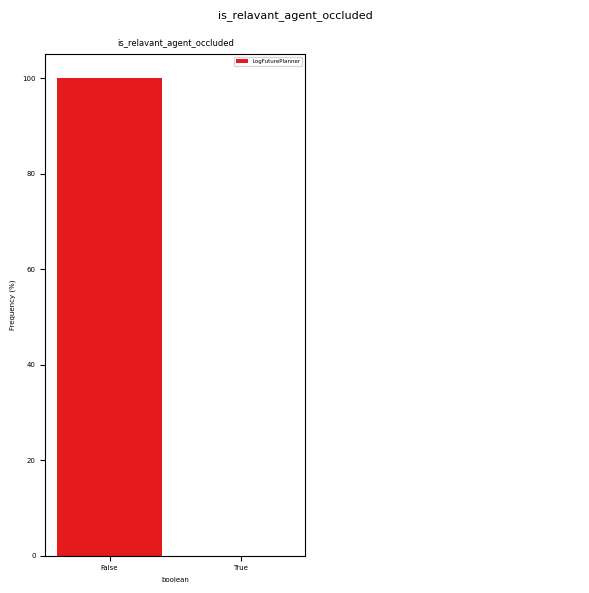

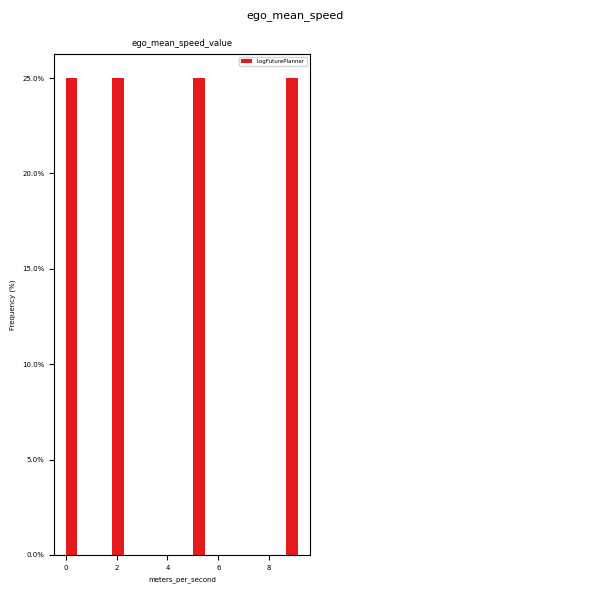

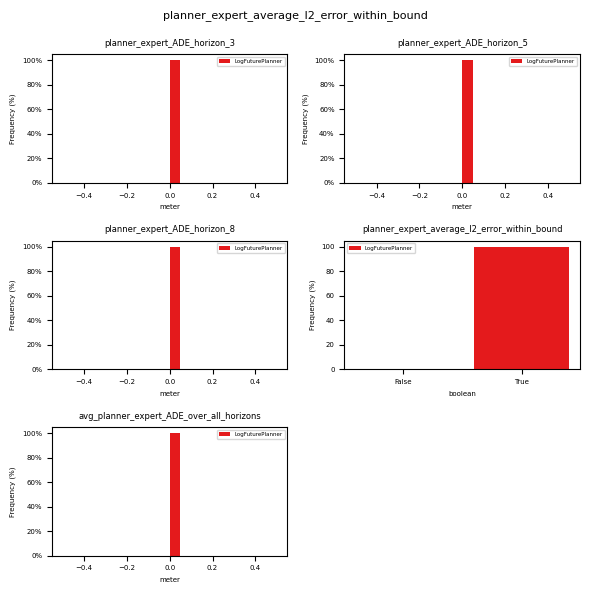

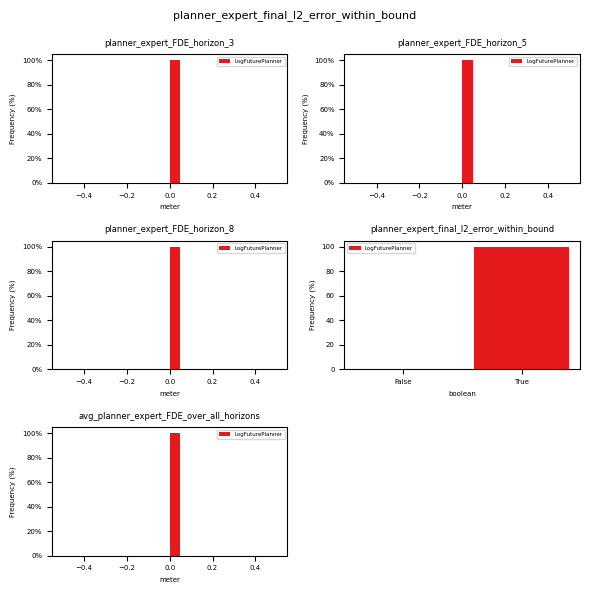

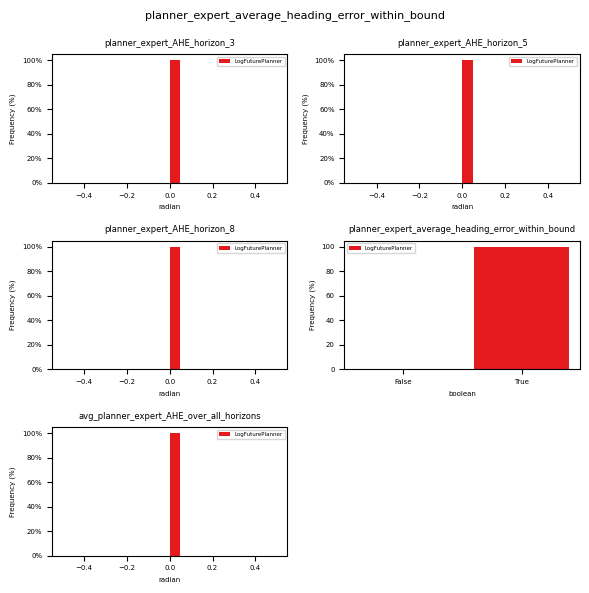

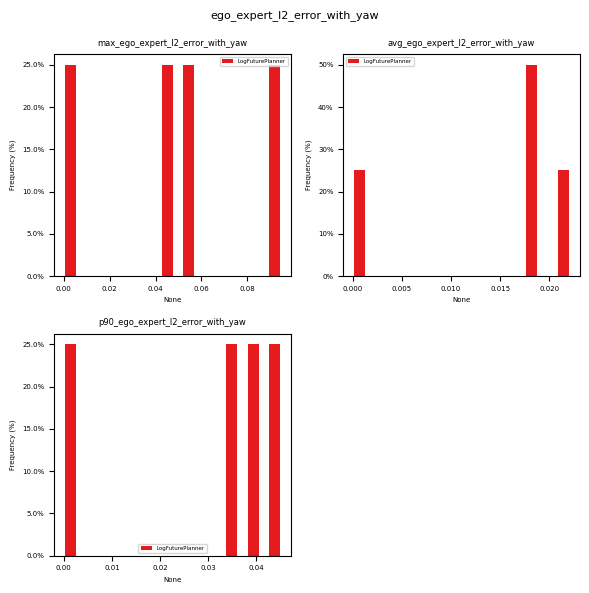

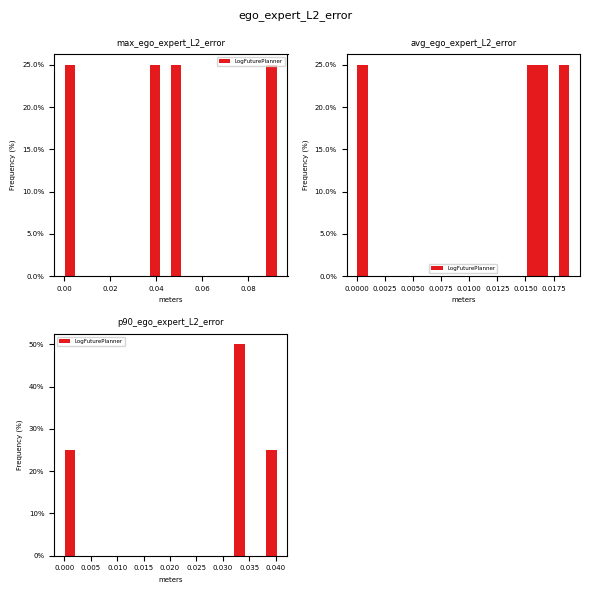

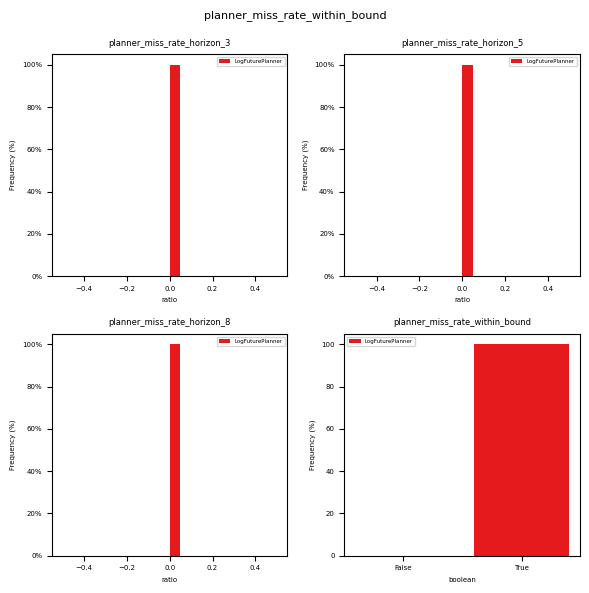

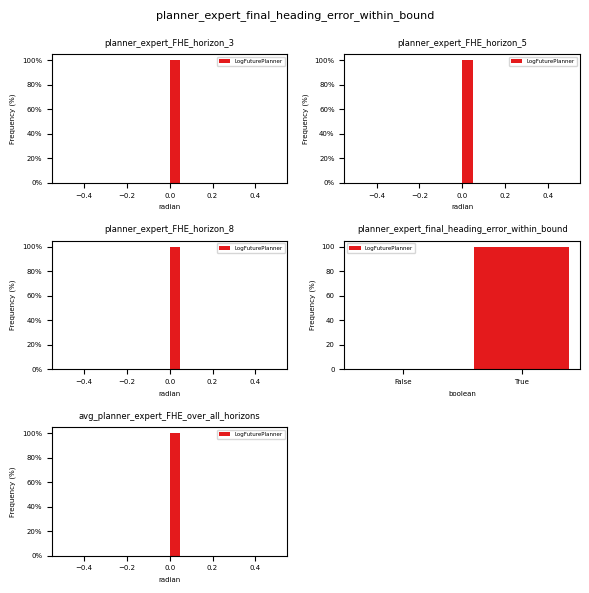

In [6]:
from nuplan.planning.script.run_simulation import main as main_simulation

# Run the simulation loop (real-time visualization not yet supported, see next section for visualization)
main_simulation(cfg)

## Prepare the nuBoard config

In [7]:
# Location of path with all nuBoard configs
CONFIG_PATH = '../nuplan/planning/script/config/nuboard'
CONFIG_NAME = 'default_nuboard'

# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=CONFIG_PATH)

# Compose the configuration
cfg = hydra.compose(config_name=CONFIG_NAME, overrides=[
    'scenario_builder=nuplan_mini',  # set the database (same as simulation) used to fetch data for visualization
    f'simulation_path={[output_folder]}',  # nuboard file path(s), if left empty the user can open the file inside nuBoard
])


## Launch nuBoard (open in new tab - recommended)

In [8]:
from nuplan.planning.script.run_nuboard import main as main_nuboard

# Run nuBoard
main_nuboard(cfg)

2023-12-08 22:08:45,633 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/scenario_building_builder.py:18}  Building AbstractScenarioBuilder...
2023-12-08 22:08:45,644 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/scenario_building_builder.py:21}  Building AbstractScenarioBuilder...DONE!
2023-12-08 22:08:45,645 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/nuboard.py:84}  Opening Bokeh application on http://localhost:5006/
2023-12-08 22:08:45,645 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/nuboard.py:85}  Async rendering is set to: True
2023-12-08 22:08:45,645 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/bokeh/server/server.py:403}  Starting Bokeh server version 2.4.3 (running on Tornado 6.3.3)
2023-12-08 22:08:45,645 WARNING {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/bokeh/server/util.py:145}  Host wildcard '*' will allow connections originating from multiple (or possib

INFO:tornado.access:200 GET / (127.0.0.1) 163.11ms


2023-12-08 22:08:47,604 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/base/simulation_tile.py:172}  Minimum frame time=0.017 s
2023-12-08 22:08:47,609 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 0.0005 seconds.
2023-12-08 22:08:47,700 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  200 GET / (127.0.0.1) 152.33ms
2023-12-08 22:08:47,709 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  101 GET /ws (127.0.0.1) 0.43ms
2023-12-08 22:08:47,709 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/bokeh/server/views/ws.py:132}  WebSocket connection opened
2023-12-08 22:08:47,709 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/bokeh/server/views/ws.py:213}  ServerConnection created


INFO:tornado.access:200 GET / (127.0.0.1) 152.33ms
INFO:tornado.access:101 GET /ws (127.0.0.1) 0.43ms


2023-12-08 22:08:58,874 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 0.0128 seconds.


Rendering a scenario: 100%|██████████| 1/1 [00:00<00:00, 32.03it/s]


2023-12-08 22:09:07,821 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 2.2702 seconds.
